## Project: Build a Traffic Sign Recognition Classifier

This notebook contains the implemetnation of Traffic sign classifier based on the LeNet architecure which is a convolution neural network. The following steps are used to create the classfier, pipeline and training process.

- Load the data.
- Understanding and Visualising the data.
- Run Benchmark model without any preprocessing.
- Preprocessing the data for usage.
- Define training set, validation set and test set.
- Design of Pipeline.
- Training of Network.
- Cross - Validation of Network.
- Measure of system performance.
- Tunning of system performance.
- Run classifier on Test data.

---
### Step 0: Load The Data

The data set provided are the traffic signs sampled from the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset), as pickled files.

In [1]:
# Load all necessary libraries
import pickle
import os
import pandas as pd
import numpy as np
from math import ceil
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
from LeNet5 import lenet5

# Visualizations will be shown in the notebook.
%matplotlib inline

In [4]:
# Load pickled data

# Root folder for the training data set
rootDir = r"./traffic-signs-data"

# Traffic sign identifier text csv file path
signcsvname = "signnames.csv"

# data set files path
training_file = os.path.join(rootDir, "train.p")
testing_file = os.path.join(rootDir, "test.p")

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
Org_X_train, Org_y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(Org_X_train, Org_y_train, test_size=0.2, random_state=0)

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [5]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = np.shape(X_train)[0]

# TODO: Number of validation examples
n_validation = np.shape(X_valid)[0]

# TODO: Number of testing examples.
n_test = np.shape(X_test)[0]

# TODO: What's the shape of an traffic sign image?
image_shape = np.shape(X_train[0])

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 27839
Number of validation examples = 6960
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

In [6]:
# A function provide a random sample of images from a given dataset and labels
def getrandomset(dataset, label, nsample):
    '''
    This function generates random dataset based on the number of sample defined.
    
    :param dataset: the entire dataset from which random sample has to be selected
    :param label: the ylabel dataset from which the indices are randomised
    :param nsample: Number of random samples to be returned
    '''
    dataset, label =  shuffle(dataset, label)
    rand_ind = np.random.choice(label, size=nsample, replace=False)
    sample_dataset = dataset[rand_ind]
    sample_label = label[rand_ind]
    
    return sample_dataset, sample_label

In [7]:
def plotrandom(dataset, label, label_dict):
    '''
    This fucntion plots the given dataset as subplot and its corresponding label.
    
    :param dataset: sample of dataset to be plotted
    :param label: identifier of the dataset
    :param label_dict: dictionary of the label identifier
    '''
    width = 12
    height = 12
    plt.figure(figsize=(width, height))
    n_dataset = np.shape(dataset)[0]
    if n_dataset <= 5:
        nrows = 1
        ncols = n_dataset
    else:
        nrows = ceil(n_dataset/5)
        ncols = 5
    for i in range(n_dataset):
        x = dataset[i]
        y = str(label[i]) + " " + label_dict[label[i]]
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(x)
        plt.axis('off')
        plt.text(0,0,y, fontsize=9, backgroundcolor='y')
    plt.show()

In [8]:
def readLabel(csvfname):
    '''
    this function reads the traffic sign label name and returns dictionary of 
    the labels.
    
    :param csvfname: filepath of the sign label identifier
    '''
    dataframe = pd.read_csv(csvfname)
    label_dict = pd.Series(dataframe.SignName, index=dataframe.ClassId).to_dict()
    
    return label_dict

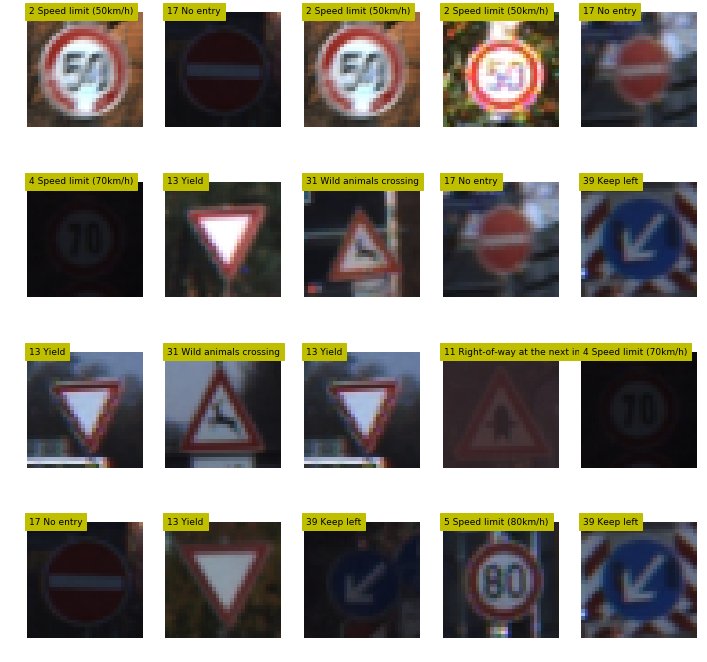

In [9]:
# Get random set of traffic sign to visualise them
dataset, label = getrandomset(X_train, y_train, 20)

# generate label dictionary to identify the traffic signs
label_dict = readLabel(signcsvname)

# Plot traffic signs
plotrandom(dataset, label, label_dict)

## Benchmark run without any normalisation

In [ ]:
# Create an Object of the LeNet5
lenet5obj = lenet5.neuralLeNet(X_train, y_train, X_valid, y_valid, X_test, y_test)

In [ ]:
# Setup Process
lenet5obj.process_setup(EPOCHS=10, BATCH_SIZE=250, mu=0, sigma=0.1,
                        inputshape=(5, 5, 3, 6), x_shape=(None, 32, 32, 3),
                        y_shape=(None), onehot_class=43, outputclass=43)

In [ ]:
# Setup training
lenet5obj.setup_train_pipe(learning_rate=0.001)

In [ ]:
# Sstart training
lenet5obj.train("Benchmark_Lenet")

----

## Step 2: Design and Test a Model Architecture

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [19]:
def normalisebystd(dataset):
    '''
    This function will normalise a given array with mean and std. Deviation
    
    :param dataset: the test or train image 4d array to be normalised
    '''
    mean = dataset.mean()
    std = dataset.std()
    dset = (dataset - mean) / std
    return dset

def simplenormalise(dataset):
    '''
    This function will normalise a given array with mean and std. Deviation
    
    :param dataset: the test or train image 4d array to be normalised
    '''
    dset = (dataset - 128) / 128
    return dset

def minmaxscaler(dataset):
    '''
    This function performs min-max scaling for a given dataset
    '''
    xmin = dataset.min()
    xmax = dataset.max()
    dset = (dataset - xmin) / (xmax - xmin)
    return dset

In [11]:
# Normalise option 1
X_train = Org_X_train.copy()
y_train = Org_y_train.copy()

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
X_train = normalisebystd(X_train)
X_valid = normalisebystd(X_valid)

In [12]:
# Re Run Network to see the Performance
# Create an Object of the LeNet5
lenet5obj_Norm1 = lenet5.neuralLeNet(X_train, y_train, X_valid, y_valid, X_test, y_test)

In [13]:
# Setup Process
lenet5obj_Norm1.process_setup(EPOCHS=10, BATCH_SIZE=250, mu=0, sigma=0.1,
                        inputshape=(5, 5, 3, 6), x_shape=(None, 32, 32, 3),
                        y_shape=(None), onehot_class=43, outputclass=43)

In [14]:
# Setup training
lenet5obj_Norm1.setup_train_pipe(learning_rate=0.001)

In [15]:
# Sstart training
lenet5obj_Norm1.train("Normalised1_Lenet")

Training...

EPOCH 1 ...
Validation Accuracy = 0.727

EPOCH 2 ...
Validation Accuracy = 0.870

EPOCH 3 ...
Validation Accuracy = 0.923

EPOCH 4 ...
Validation Accuracy = 0.951

EPOCH 5 ...
Validation Accuracy = 0.953

EPOCH 6 ...
Validation Accuracy = 0.961

EPOCH 7 ...
Validation Accuracy = 0.957

EPOCH 8 ...
Validation Accuracy = 0.952

EPOCH 9 ...
Validation Accuracy = 0.968

EPOCH 10 ...
Validation Accuracy = 0.976

Model saved


In [ ]:
# Normalise Option 2

In [16]:
X_train = Org_X_train.copy()
y_train = Org_y_train.copy()

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
X_train = simplenormalise(X_train)
X_valid = simplenormalise(X_valid)

# Re Run Network to see the Performance
# Create an Object of the LeNet5
lenet5obj_Norm2 = lenet5.neuralLeNet(X_train, y_train, X_valid, y_valid, X_test, y_test)

# Setup Process
lenet5obj_Norm2.process_setup(EPOCHS=10, BATCH_SIZE=250, mu=0, sigma=0.1,
                        inputshape=(5, 5, 3, 6), x_shape=(None, 32, 32, 3),
                        y_shape=(None), onehot_class=43, outputclass=43)

# Setup training
lenet5obj_Norm2.setup_train_pipe(learning_rate=0.001)

# Sstart training
lenet5obj_Norm2.train("Normalised2_Lenet")

Training...

EPOCH 1 ...
Validation Accuracy = 0.271

EPOCH 2 ...
Validation Accuracy = 0.484

EPOCH 3 ...
Validation Accuracy = 0.629

EPOCH 4 ...
Validation Accuracy = 0.717

EPOCH 5 ...
Validation Accuracy = 0.767

EPOCH 6 ...
Validation Accuracy = 0.801

EPOCH 7 ...
Validation Accuracy = 0.830

EPOCH 8 ...
Validation Accuracy = 0.846

EPOCH 9 ...
Validation Accuracy = 0.846

EPOCH 10 ...
Validation Accuracy = 0.844

Model saved


In [20]:
# Normalisation option 3
X_train = Org_X_train.copy()
y_train = Org_y_train.copy()

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
X_train = minmaxscaler(X_train)
X_valid = minmaxscaler(X_valid)

# Re Run Network to see the Performance
# Create an Object of the LeNet5
lenet5obj_Norm3 = lenet5.neuralLeNet(X_train, y_train, X_valid, y_valid, X_test, y_test)

# Setup Process
lenet5obj_Norm3.process_setup(EPOCHS=10, BATCH_SIZE=250, mu=0, sigma=0.1,
                        inputshape=(5, 5, 3, 6), x_shape=(None, 32, 32, 3),
                        y_shape=(None), onehot_class=43, outputclass=43)

# Setup training
lenet5obj_Norm3.setup_train_pipe(learning_rate=0.001)

# Sstart training
lenet5obj_Norm3.train("Normalised3_Lenet")

Training...

EPOCH 1 ...
Validation Accuracy = 0.617

EPOCH 2 ...
Validation Accuracy = 0.811

EPOCH 3 ...
Validation Accuracy = 0.870

EPOCH 4 ...
Validation Accuracy = 0.877

EPOCH 5 ...
Validation Accuracy = 0.918

EPOCH 6 ...
Validation Accuracy = 0.926

EPOCH 7 ...
Validation Accuracy = 0.931

EPOCH 8 ...
Validation Accuracy = 0.940

EPOCH 9 ...
Validation Accuracy = 0.943

EPOCH 10 ...
Validation Accuracy = 0.955

Model saved


### Model Architecture

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [ ]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")